# Notebook setup


In [1]:
# %config Completer.use_jedi = False
%config IPCompleter.greedy=True

import importlib
import sys
from urllib.request import urlretrieve

# TODO(russt): install only drake (not manipulation) after colab gets to python3.8
if 'google.colab' in sys.modules and importlib.util.find_spec('manipulation') is None:
    urlretrieve(f"http://manipulation.csail.mit.edu/scripts/setup/setup_manipulation_colab.py",
                "setup_manipulation_colab.py")
    from setup_manipulation_colab import setup_manipulation
    setup_manipulation(manipulation_sha='c1bdae733682f8a390f848bc6cb0dbbf9ea98602', drake_version='0.27.0', drake_build='release')

# Install pyngrok.
server_args = []
if 'google.colab' in sys.modules:
  server_args = ['--ngrok_http_tunnel']

# Start a single meshcat server instance to use for the remainder of this notebook.
from meshcat.servers.zmqserver import start_zmq_server_as_subprocess
proc, zmq_url, web_url = start_zmq_server_as_subprocess(server_args=server_args)

from manipulation import running_as_notebook

# Imports
import numpy as np
import pydot
from ipywidgets import Dropdown, Layout
from IPython.display import display, HTML, SVG

from pydrake.all import (
    AddMultibodyPlantSceneGraph, ConnectMeshcatVisualizer, DiagramBuilder, 
    FindResourceOrThrow, GenerateHtml, InverseDynamicsController, 
    MultibodyPlant, Parser, Simulator)
from pydrake.multibody.jupyter_widgets import MakeJointSlidersThatPublishOnCallback
import pydrake
from pydrake import geometry
from pydrake.math import RigidTransform, RollPitchYaw, RotationMatrix 

# Robot arms


In [2]:
builder = DiagramBuilder()
plant, scene_graph = AddMultibodyPlantSceneGraph(builder, time_step=1e-4)

In [3]:
#add iiwa
iiwa = pydrake.multibody.parsing.Parser(plant, scene_graph).AddModelFromFile(
    pydrake.common.FindResourceOrThrow(
#         "drake/manipulation/models/iiwa_description/iiwa7/iiwa7_with_box_collision.sdf")
    "drake/manipulation/models/iiwa_description/urdf/iiwa14_spheres_dense_collision.urdf")
)

# plant.WeldFrames(plant.world_frame(), plant.GetFrameByName("iiwa_link_0"))
plant.WeldFrames(plant.world_frame(), plant.GetFrameByName("base"))

# Set default positions:
q0 = [0.0, 0.1, 0, -1.2, 0, 1.6, 0]
index = 0
for joint_index in plant.GetJointIndices(iiwa):
    joint = plant.get_mutable_joint(joint_index)
    if isinstance(joint, pydrake.multibody.tree.RevoluteJoint):
        joint.set_default_angle(q0[index])
        index += 1

        
#add gripper
gripper = pydrake.multibody.parsing.Parser(plant, scene_graph).AddModelFromFile(
            pydrake.common.FindResourceOrThrow(
                "drake/manipulation/models/"
                "wsg_50_description/sdf/schunk_wsg_50_no_tip_sphere_collision.sdf"))

X_7G = RigidTransform(RollPitchYaw(np.pi / 2.0, 0, np.pi / 2.0), [0, 0, 0.114])
plant.WeldFrames(plant.GetFrameByName("iiwa_link_7", iiwa),
                 plant.GetFrameByName("body", gripper), X_7G)

#open gripper
q0 = [-0.054, 0.054]
index = 0
for joint_index in plant.GetJointIndices(gripper):
    joint = plant.get_mutable_joint(joint_index)
    if isinstance(joint, pydrake.multibody.tree.PrismaticJoint):
        joint.set_default_translation(q0[index])
        index += 1



#add brick
brick = pydrake.multibody.parsing.Parser(plant, scene_graph).AddModelFromFile(
            pydrake.common.FindResourceOrThrow(
                "drake/examples/manipulation_station/models/061_foam_brick_sphere_collision.sdf"))

X_GB = RigidTransform(RotationMatrix.MakeYRotation(np.pi/2.0), [-0.02, 0.1, 0.])
grasp_point_joint_frame = plant.AddFrame(pydrake.multibody.tree.FixedOffsetFrame("grasp_point_joint_frame", 
                            plant.GetFrameByName("body", gripper), X_GB))
grasp_point_joint = plant.AddJoint(pydrake.multibody.tree.PrismaticJoint("grasp_point_joint", grasp_point_joint_frame,
                                                     plant.GetFrameByName("base_link", brick), 
                                                     np.array([1., 0., 0.]), -0.3, 0.3))

plant.Finalize()
plant.set_name("plant")

In [4]:
# from pydrake.solvers.mathematicalprogram import MathematicalProgram, Solve
# from pydrake.all import RigidTransform_, RotationMatrix_
# from pydrake.autodiffutils import AutoDiffXd

# prog = MathematicalProgram()

# x = prog.NewContinuousVariables(1)


# X_GB = RigidTransform_[AutoDiffXd](RotationMatrix_[AutoDiffXd].MakeYRotation(np.pi/2.0), np.array([-0.02, 0.1, x], dtype=np.float))
# # X_GB = RigidTransform_[AutoDiffXd](RotationMatrix_.MakeYRotation(np.pi/2.0), [-0.02, 0.1, x])
# plant.WeldFrames(plant.GetFrameByName("body", gripper),
#                  plant.GetFrameByName("base_link", brick), X_GB)
    
# plant.Finalize()

In [5]:
# Adds the MeshcatVisualizer and wires it to the SceneGraph.
# meshcat = ConnectMeshcatVisualizer(builder, scene_graph, zmq_url=zmq_url)
diagram = builder.Build()

In [6]:
print(diagram)
diagram_ad = diagram.ToAutoDiffXd()
context = diagram.CreateDefaultContext()
# meshcat.load()
diagram.Publish(context)

<pydrake.systems.framework.Diagram_[float] object at 0x7f2f03e14af0>


In [7]:
plant_context = plant.GetMyContextFromRoot(context)
# Get the current object, O, pose
X_WOstart = plant.EvalBodyPoseInWorld(plant_context, plant.GetBodyByName("base_link", brick))
X_OstartOend = RigidTransform(RollPitchYaw(np.pi / 2.0, 0, np.pi / 2.0), [0, 0.3, 0.2])
X_WOend = X_WOstart.multiply(X_OstartOend)
X_O = {"start": X_WOstart, "end": X_WOend}
times = {"start": 0., "end": 10.}

In [8]:
from pydrake.all import (
    PiecewisePolynomial, PiecewiseQuaternionSlerp
)
def make_object_position_trajectory(X_O, times):
    """
    Constructs a brick position trajectory from the start to end.
    """

    traj = PiecewisePolynomial.FirstOrderHold(
        [times["start"], times["end"]], np.vstack([X_O["start"].translation(), X_O["end"].translation()]).T)


    return traj


def make_object_orientation_trajectory(X_O, times):
    """
    Constructs a brick orientation trajectory from the start to end.
    """
    traj = PiecewiseQuaternionSlerp();
    traj.Append(times["start"], X_O["start"].rotation())
    traj.Append(times["end"], X_O["end"].rotation())

    return traj


traj_p_O = make_object_position_trajectory(X_O, times)
traj_R_O = make_object_orientation_trajectory(X_O, times)
traj_v_O = traj_p_O.MakeDerivative()
traj_w_O = traj_R_O.MakeDerivative()

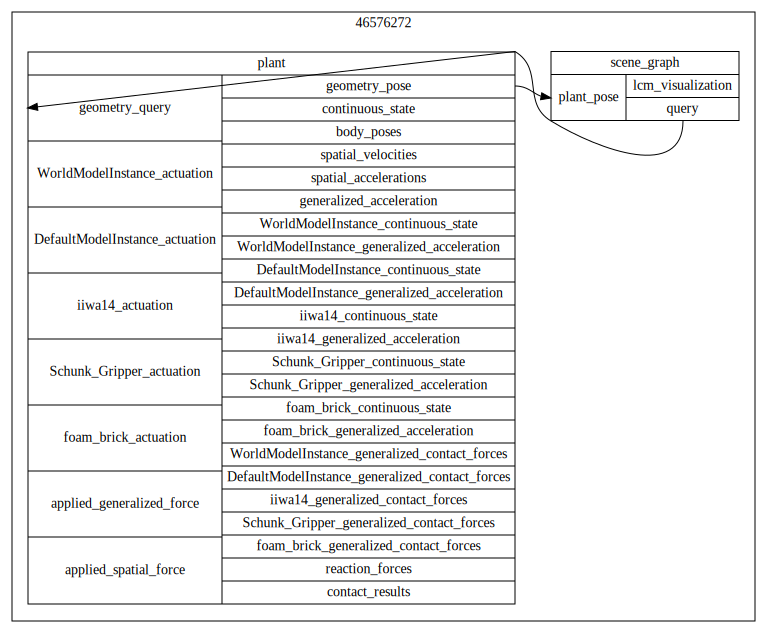

In [9]:
display(SVG(pydot.graph_from_dot_data(diagram.GetGraphvizString())[0].create_svg()))

In [10]:
from pydrake.all import JacobianWrtVariable, Quaternion, eq
from pydrake.solvers.mathematicalprogram import MathematicalProgram, Solve

plant_ad = diagram_ad.GetSubsystemByName("plant")  
#     plant_ad = plant.ToAutoDiffXd()
#     print(plant_ad)
context_ad = diagram_ad.CreateDefaultContext()
plant_context_ad = plant_ad.GetMyContextFromRoot(context_ad)
#     print(context_ad)
#     print(plant_context_ad)

O_frame = plant_ad.GetFrameByName("base_link", brick)
W = plant_ad.world_frame()
J_O1 = plant_ad.CalcJacobianSpatialVelocity(
            plant_context_ad, JacobianWrtVariable.kV, 
            O_frame, [0,0,0], W, W)

# print( np.linalg.det(np.matmul(J_O1, J_O1.transpose())))

def calc_energy(q):
    
    t = traj_p_O.start_time()
    k = 0
    total_energy = 0
    while t <= traj_p_O.end_time():

        #differential kinematics derive qd_dot  and set plant_context velocity
        w_O = traj_w_O.value(t)
        v_O = traj_v_O.value(t)
        V_O = np.vstack((w_O, v_O))

        plant_ad.SetPositions(plant_context_ad, q[k * 10 : (k + 1) * 10])
        J_O = plant_ad.CalcJacobianSpatialVelocity(
            plant_context_ad, JacobianWrtVariable.kV, 
            O_frame, [0,0,0], W, W)
        iiwa_start = plant_ad.GetJointByName("iiwa_joint_1").velocity_start()
        iiwa_end = plant_ad.GetJointByName("iiwa_joint_7").velocity_start()
        J_O = J_O[:,iiwa_start:iiwa_end + 1] # Only iiwa terms.
        qd_dot = pydrake.math.inv(J_O).T.dot(V_O) #.T[0]


#         print(qd_dot)

        plant_ad.SetVelocities(plant_context_ad, iiwa, qd_dot)
# #         print(plant_context.get_state().get_discrete_state().get_data())
# #         print("***************************\n")

        #Calc Energy
        K_energy = plant_ad.CalcKineticEnergy(plant_context_ad)
        P_energy = plant_ad.CalcPotentialEnergy(plant_context_ad)
#             print("K_energy: ",K_energy,"  P_energy: ", P_energy)
        energy = K_energy + P_energy
        total_energy = total_energy + energy


#         #Calc manipulabity
#         print("rankJ: ", np.linalg.matrix_rank(J_O))
#         manipulabity = np.sqrt(np.linalg.det(np.matmul(J_O, J_O.transpose())))
#         print("manipulabity: ", manipulabity)
#         print("***************************\n")



        t = t + 0.2
        k = k + 1
    return total_energy

In [11]:
prog = MathematicalProgram()
    
N = plant_ad.num_positions() 
M = 51
q = prog.NewContinuousVariables(rows=N, cols=M, name='q')
q0 = plant.GetPositions(plant_context)
for i in range(M):
    prog.AddBoundingBoxConstraint(plant_ad.GetPositionLowerLimits(),
                                plant_ad.GetPositionUpperLimits(), q[:, i])
    prog.SetInitialGuess(q[:,i], q0)

for i in range(M - 1):
    prog.AddLinearConstraint(q[N - 1, i] == q[N - 1, i + 1])
#         prog.AddConstraint(eq(np.array(q[i, M - 1]), np.array(q[i + 1, M - 1])))
for i in range(M):
    prog.AddLinearConstraint(q[N - 2, i] == 0.054)
    prog.AddLinearConstraint(q[N - 3, i] == -0.054)


t = traj_p_O.start_time()
k = 0
while t <= traj_p_O.end_time():
    X_WO = RigidTransform(Quaternion(traj_R_O.value(t)), traj_p_O.value(t))

#         X_WO_ad = plant.CalcRelativeTransform(plant_context_ad, W, O_frame)

#         prog.AddConstraint(eq(X_WO_ad, X_WO))
    prog.AddConstraint(pydrake.multibody.inverse_kinematics.PositionConstraint(plant_ad, 
            W, X_WO.translation(), X_WO.translation(), 
                                        O_frame, np.array([0., 0., 0.]), plant_context_ad), q[:, k])
    prog.AddConstraint(pydrake.multibody.inverse_kinematics.OrientationConstraint(plant_ad, 
                                             W, RotationMatrix(),
                                             O_frame, RotationMatrix(), 
                                             0., plant_context_ad), q[:, k])
    prog.AddConstraint(pydrake.multibody.inverse_kinematics.MinimumDistanceConstraint(plant_ad, 
                                                 0.001, plant_context_ad, None, 0.1), q[:, k])


#         def calc_energy(qk):

#             #differential kinematics derive qd_dot  and set plant_context velocity
#             w_O = traj_w_O.value(t)
#             v_O = traj_v_O.value(t)
#             V_O = np.vstack((w_O, v_O))

#             plant_ad.SetPositions(plant_context_ad, qk)
#             J_O = plant.CalcJacobianSpatialVelocity(
#                 plant_context, JacobianWrtVariable.kV, 
#                 O_frame, [0,0,0], W, W)
#             iiwa_start = plant_ad.GetJointByName("iiwa_joint_1").velocity_start()
#             iiwa_end = plant_ad.GetJointByName("iiwa_joint_7").velocity_start()
#             J_O = J_O[:,iiwa_start:iiwa_end+1] # Only iiwa terms.
#             qd_dot = np.linalg.pinv(J_O).dot(V_O).T[0]
#         print(qd_dot)

#             plant_ad.SetVelocities(plant_context_ad, iiwa, qd_dot)
# #         print(plant_context.get_state().get_discrete_state().get_data())
# #         print("***************************\n")

        #Calc Energy
#             K_energy = plant.CalcKineticEnergy(plant_context_ad)
#             P_energy = plant.CalcPotentialEnergy(plant_context_ad)
#             print("K_energy: ",K_energy,"  P_energy: ", P_energy)
#             return K_energy + P_energy

#         #Calc manipulabity
#         print("rankJ: ", np.linalg.matrix_rank(J_O))
#         manipulabity = np.sqrt(np.linalg.det(np.matmul(J_O, J_O.transpose())))
#         print("manipulabity: ", manipulabity)
#         print("***************************\n")

    t = t + 0.2
    k = k + 1


vars = []
for i in range(M):
    vars = np.concatenate((vars, q[:, i]))
prog.AddCost(calc_energy, vars=vars)

result = pydrake.solvers.mathematicalprogram.Solve(prog)
if not result.is_success():
    print("IK failed!")
    print(result.GetInfeasibleConstraintNames(prog))
else:
    print("IK success")
    q_sol = result.GetSolution(q)
    print(q_sol)

IK failed!
['drake::multibody::MinimumDistanceConstraint[0]: -inf <= 1.820000 <= 1.000000', 'drake::multibody::MinimumDistanceConstraint[0]: -inf <= 1.820000 <= 1.000000', 'drake::multibody::MinimumDistanceConstraint[0]: -inf <= 1.820000 <= 1.000000', 'drake::multibody::MinimumDistanceConstraint[0]: -inf <= 1.820000 <= 1.000000', 'drake::multibody::MinimumDistanceConstraint[0]: -inf <= 1.820000 <= 1.000000', 'drake::multibody::MinimumDistanceConstraint[0]: -inf <= 1.820000 <= 1.000000', 'drake::multibody::MinimumDistanceConstraint[0]: -inf <= 1.820000 <= 1.000000', 'drake::multibody::MinimumDistanceConstraint[0]: -inf <= 1.820000 <= 1.000000', 'drake::multibody::MinimumDistanceConstraint[0]: -inf <= 1.820000 <= 1.000000', 'drake::multibody::MinimumDistanceConstraint[0]: -inf <= 1.820000 <= 1.000000', 'drake::multibody::MinimumDistanceConstraint[0]: -inf <= 1.820000 <= 1.000000', 'drake::multibody::MinimumDistanceConstraint[0]: -inf <= 1.820000 <= 1.000000', 'drake::multibody::MinimumDi

In [12]:
from pydrake.all import RigidTransform_, RotationMatrix_, Frame_
from pydrake.autodiffutils import AutoDiffXd
from pydrake.all import (
    PiecewisePolynomial, PiecewiseQuaternionSlerp, Simulator_, autoDiffToGradientMatrix, autoDiffToValueMatrix
)


# X_GB = RigidTransform_[AutoDiffXd](RotationMatrix_[AutoDiffXd].MakeYRotation(np.pi/2.0), np.array([-0.02, 0.1, x], dtype=np.float))
# # X_GB = RigidTransform_[AutoDiffXd](RotationMatrix_.MakeYRotation(np.pi/2.0), [-0.02, 0.1, x])


def inverse_and_collision_constrain(x):
    builder = DiagramBuilder()
    plant, scene_graph = AddMultibodyPlantSceneGraph(builder, time_step=1e-4)
    #add iiwa
    iiwa = pydrake.multibody.parsing.Parser(plant, scene_graph).AddModelFromFile(
        pydrake.common.FindResourceOrThrow(
            "drake/manipulation/models/iiwa_description/iiwa7/iiwa7_with_box_collision.sdf")
    )

    plant.WeldFrames(plant.world_frame(), plant.GetFrameByName("iiwa_link_0"))

    # Set default positions:
    q0 = [0.8, 0.1, 0, -1.2, 0, 1.6, 0]
    index = 0
    for joint_index in plant.GetJointIndices(iiwa):
        joint = plant.get_mutable_joint(joint_index)
        if isinstance(joint, pydrake.multibody.tree.RevoluteJoint):
            joint.set_default_angle(q0[index])
            index += 1


    #add gripper
    gripper = pydrake.multibody.parsing.Parser(plant, scene_graph).AddModelFromFile(
                pydrake.common.FindResourceOrThrow(
                    "drake/manipulation/models/"
                    "wsg_50_description/sdf/schunk_wsg_50_no_tip.sdf"))

    X_7G = RigidTransform(RollPitchYaw(np.pi / 2.0, 0, np.pi / 2.0), [0, 0, 0.114])
    plant.WeldFrames(plant.GetFrameByName("iiwa_link_7", iiwa),
                     plant.GetFrameByName("body", gripper), X_7G)
    
    

    #open gripper
    q0 = [-0.054, 0.054]
    index = 0
    for joint_index in plant.GetJointIndices(gripper):
        joint = plant.get_mutable_joint(joint_index)
        if isinstance(joint, pydrake.multibody.tree.PrismaticJoint):
            joint.set_default_translation(q0[index])
            index += 1



    #add brick  as free body
    brick = pydrake.multibody.parsing.Parser(plant, scene_graph).AddModelFromFile(
                pydrake.common.FindResourceOrThrow(
                    "drake/examples/manipulation_station/models/061_foam_brick.sdf"))
    
    grasp_point = plant.AddModelInstance("grasp_point")
    grasp_point_body = plant.AddRigidBody("grasp_point_body", grasp_point, pydrake.multibody.tree.SpatialInertia(0, [0,0,0], pydrake.multibody.tree.UnitInertia(0,0,0)))
    grasp_point_joint = plant.AddJoint(pydrake.multibody.tree.PrismaticJoint("grasp_point_joint", plant.GetFrameByName("base_link", brick),
                                                     grasp_point_body.body_frame(), 
                                                     np.array([1., 0., 0.]), -0.3, 0.3))
    grasp_point_joint.set_default_translation(0.7)
    
    plant.Finalize()
    plant.set_name("plant")

#     trans = np.array([-0.02, 0.1])
#     trans = np.hstack([trans, x])
#     X_GB = RigidTransform_[AutoDiffXd](RotationMatrix_[AutoDiffXd].MakeYRotation(np.pi/2.0), trans)
# #     X_GB = RigidTransform(RotationMatrix.MakeYRotation(np.pi/2.0), [-0.02, 0.1, x])
#     plant = plant.ToAutoDiffXd()
#     plant.WeldFrames(plant.GetFrameByName("body", gripper),
#                      plant.GetFrameByName("base_link", brick), X_GB)
    
#     meshcat = ConnectMeshcatVisualizer(builder, scene_graph, zmq_url=zmq_url)
    diagram = builder.Build()
    print(diagram)
    diagram_ad = diagram.ToAutoDiffXd()
#     plant_ad = diagram.GetSubsystemByName("plant")    #why here is not derive AutodiffDX ??
#     context_ad = diagram_ad.CreateDefaultContext()
#     meshcat.load()
#     diagram_ad.Publish(context)

#     simulator = Simulator_[AutoDiffXd](diagram_ad)
#     context_ad = simulator.get_mutable_context()
#     plant_context_ad = plant_ad.GetMyContextFromRoot(context_ad)
    
    plant_ad = plant.ToAutoDiffXd()
    plant_context_ad = plant_ad.CreateDefaultContext()
    plant_context = plant.CreateDefaultContext()
    
    # Get the current object, O, pose
    X_WOstart = plant.EvalBodyPoseInWorld(plant_context, plant.GetBodyByName("base_link", brick))
    p_WOstart = X_WOstart.translation() + np.array([0.1, 0., 0])
    X_WOstart = RigidTransform(X_WOstart.rotation(), p_WOstart)
    X_OstartOend = RigidTransform(RollPitchYaw(np.pi / 2.0, 0, np.pi / 2.0), [0, 0.3, 0.2])
    X_WOend = X_WOstart.multiply(X_OstartOend)
    X_O = {"start": X_WOstart, "end": X_WOend}
    times = {"start": 0., "end": 10.}

    def make_object_position_trajectory(X_O, times):
        """
        Constructs a brick position trajectory from the start to end.
        """

        traj = PiecewisePolynomial.FirstOrderHold(
            [times["start"], times["end"]], np.vstack([X_O["start"].translation(), X_O["end"].translation()]).T)


        return traj


    def make_object_orientation_trajectory(X_O, times):
        """
        Constructs a brick orientation trajectory from the start to end.
        """
        traj = PiecewiseQuaternionSlerp();
        traj.Append(times["start"], X_O["start"].rotation())
        traj.Append(times["end"], X_O["end"].rotation())

        return traj


    traj_p_O = make_object_position_trajectory(X_O, times)
    traj_R_O = make_object_orientation_trajectory(X_O, times)
    traj_v_O = traj_p_O.MakeDerivative()
    traj_w_O = traj_R_O.MakeDerivative()
    
    print("q00:",plant.GetPositions(plant_context))
    
    G_frame = plant_ad.GetFrameByName("body", gripper)
    W = plant_ad.world_frame()
    grasp_point_frame_ad = plant_ad.GetFrameByName("grasp_point_body")
    grasp_point_joint_ad = plant_ad.GetJointByName("grasp_point_joint")
    print(x)
#     print(plant_context)
    t = traj_p_O.start_time()
    while t <= traj_p_O.end_time():
        grasp_point_joint_ad.set_translation(plant_context_ad, x[0])
        
        X_WO = RigidTransform(Quaternion(traj_R_O.value(t)), traj_p_O.value(t))
        plant_ad.SetFreeBodyPose(plant_context_ad, plant_ad.GetBodyByName("base_link", brick), X_WO.cast[AutoDiffXd]())
        
        trans = np.array([-0.02, 0.1])
        trans = np.hstack([trans, x[0]])
        X_GO = RigidTransform_[AutoDiffXd](RotationMatrix_[AutoDiffXd].MakeYRotation(np.pi/2.0), trans)
        X_WG = X_WO.cast[AutoDiffXd]().multiply(X_GO.inverse())

#         X_WG = autoDiffToGradientMatrix(X_WG)
        #inverse kinematics derive qd
        q0 = plant_ad.GetPositions(plant_context_ad)
        q0 = pydrake.autodiffutils.autoDiffToValueMatrix(q0)
        print("q0:",q0)
        inverse_prog = MathematicalProgram()
        q = inverse_prog.NewContinuousVariables(plant_ad.num_positions(), "q")

        inverse_prog.AddBoundingBoxConstraint(plant_ad.GetPositionLowerLimits(),
                                    plant_ad.GetPositionUpperLimits(), q)
        pydrake.multibody.inverse_kinematics.AddUnitQuaternionConstraintOnPlant(plant_ad, q, inverse_prog)
#         ik.AddMinimumDistanceConstraint(0.001, 0.1)
        inverse_prog.AddConstraint(pydrake.multibody.inverse_kinematics.PositionConstraint(plant_ad, 
                grasp_point_frame_ad, np.array([0., 0., 0.]), np.array([0., 0., 0.]), 
                                            G_frame, np.array([0., 0., 0.]), plant_context_ad), q)
    
#         inverse_prog.AddConstraint(pydrake.multibody.inverse_kinematics.PositionConstraint(plant_ad, 
#                 W, trans, trans, 
#                                             G_frame, np.array([0., 0., 0.]), plant_context_ad), q)
#         ik.AddPositionConstraint(G_frame, [0, 0, 0], W, X_WG.translation(), X_WG.translation())
#         ik.AddOrientationConstraint(G_frame, RotationMatrix(), W, X_WG.rotation(), 0)
#         prog = ik.get_mutable_prog()
#         q = ik.q()
        inverse_prog.AddQuadraticErrorCost(np.identity(len(q)), q0, q)
        inverse_prog.SetInitialGuess(q, q0)
        result = pydrake.solvers.mathematicalprogram.Solve(inverse_prog)
        if not result.is_success():
#             print("IK failed!")
            print(result.GetInfeasibleConstraintNames(prog))
            return (X_WG.translation().dot(X_WG.translation()) - X_WG.translation().dot(X_WG.translation()))
        else:
            print("IK success")
            q_sol = result.GetSolution(q)
            print("q_sol:", q_sol)
        
        
        
        
        
        
#         #differential kinematics derive qd_dot  and set plant_context velocity
#         w_O = traj_w_O.value(t)
#         v_O = traj_v_O.value(t)
#         V_O = np.vstack((w_O, v_O))
#         J_O = plant.CalcJacobianSpatialVelocity(
#             plant_context, JacobianWrtVariable.kV, 
#             B_frame, [0,0,0], W, W)
#         iiwa_start = plant.GetJointByName("iiwa_joint_1").velocity_start()
#         iiwa_end = plant.GetJointByName("iiwa_joint_7").velocity_start()
#         J_O = J_O[:,iiwa_start:iiwa_end+1] # Only iiwa terms.
#         qd_dot = np.linalg.pinv(J_O).dot(V_O).T[0]
# #         print(qd_dot)
        
#         plant.SetVelocities(plant_context, iiwa, qd_dot)
# #         print(plant_context.get_state().get_discrete_state().get_data())
# #         print("***************************\n")
        
#         #Calc Energy
#         K_energy = plant.CalcKineticEnergy(plant_context)
#         P_energy = plant.CalcPotentialEnergy(plant_context)
#         print("K_energy: ",K_energy,"  P_energy: ", P_energy)
        
#         #Calc manipulabity
#         print("rankJ: ", np.linalg.matrix_rank(J_O))
#         manipulabity = np.sqrt(np.linalg.det(np.matmul(J_O, J_O.transpose())))
#         print("manipulabity: ", manipulabity)
#         print("***************************\n")
        
        t = t + 0.5
    return (X_WG.translation().dot(X_WG.translation()) - X_WG.translation().dot(X_WG.translation()) + 1)
inverse_and_collision_constrain_vector = lambda x: [inverse_and_collision_constrain(x)]

In [12]:
# inverse_and_collision_constrain(0.1)

In [13]:
from pydrake.solvers.mathematicalprogram import MathematicalProgram, Solve

prog = MathematicalProgram()

x = prog.NewContinuousVariables(1)
x0 = np.array([5.35])
# Add basic cost. (This will be parsed into a QuadraticCost.)
prog.AddCost((x - x0).dot(x - x0))
prog.AddConstraint(inverse_and_collision_constrain_vector, lb=[1], ub=[1], vars=x)

In [14]:
result = Solve(prog, initial_guess=x0)

print(f"Success? {result.is_success()}")
print(result.get_solution_result())
x_sol = result.GetSolution(x)
print(x_sol)

<pydrake.systems.framework.Diagram_[float] object at 0x7f9b3b5bfbf0>
q00: [ 1.     0.     0.     0.     0.     0.     0.     0.8    0.7    0.1
  0.    -1.2    0.     1.6    0.    -0.054  0.054]
[<AutoDiffXd 5.35 nderiv=1>]
q0: [[1.  ]
 [0.  ]
 [0.  ]
 [0.  ]
 [0.1 ]
 [0.  ]
 [0.  ]
 [0.  ]
 [5.35]
 [0.  ]
 [0.  ]
 [0.  ]
 [0.  ]
 [0.  ]
 [0.  ]
 [0.  ]
 [0.  ]]
IK success
q_sol: [ 0.93083094  0.         -0.36545008  0.          0.26892652  0.
  0.98788258  0.          0.3         0.33903263  0.         -0.27142343
  0.          0.10048702  0.          0.          0.        ]
q0: [[ 0.99862953]
 [ 0.03021618]
 [ 0.03021618]
 [ 0.03021618]
 [ 0.1       ]
 [ 0.015     ]
 [ 0.01      ]
 [ 0.        ]
 [ 5.35      ]
 [ 0.33903263]
 [ 0.        ]
 [-0.27142343]
 [ 0.        ]
 [ 0.10048702]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]]
IK success
q_sol: [ 9.75795134e-01  3.67210383e-02 -2.14294380e-01  2.35231776e-02
  5.51736824e-01  5.07495367e-03  6.65805701e-01  1.45579626e-02
  3.000000

q0: [[ 0.93358043]
 [ 0.20690383]
 [ 0.20690383]
 [ 0.20690383]
 [ 0.1       ]
 [ 0.105     ]
 [ 0.07      ]
 [ 0.18483731]
 [ 5.35000348]
 [ 1.29695212]
 [ 0.12424235]
 [-1.37611725]
 [ 0.01808196]
 [ 0.5240138 ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]]
IK success
q_sol: [ 0.94231825  0.19704847  0.21606644  0.16286037  0.22266544  0.08521263
 -0.00627878  0.21919147  0.3         1.30985014  0.16000402 -1.43087799
  0.02416048  0.54797367  0.          0.          0.        ]
q0: [[ 0.91354546]
 [ 0.23482951]
 [ 0.23482951]
 [ 0.23482951]
 [ 0.1       ]
 [ 0.12      ]
 [ 0.08      ]
 [ 0.21919147]
 [ 5.35000348]
 [ 1.30985014]
 [ 0.16000402]
 [-1.43087799]
 [ 0.02416048]
 [ 0.54797367]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]]
IK success
q_sol: [ 0.92402458  0.22266108  0.24677226  0.1889552   0.19668981  0.09505901
  0.00162434  0.25264188  0.3         1.31135818  0.19838854 -1.47181498
  0.03094868  0.56708915  0.          0.          0.        ]
q0: [[ 0.89100652]
 [ 0.2621

IK success
q_sol: [ 0.90364632  0.24830866  0.27472137  0.21516111  0.17915927  0.10575407
  0.01262857  0.28536454  0.3         1.30559446  0.23890686 -1.50274725
  0.03835558  0.58261244  0.          0.          0.        ]
q0: [[ 0.8660254 ]
 [ 0.28867513]
 [ 0.28867513]
 [ 0.28867513]
 [ 0.1       ]
 [ 0.15      ]
 [ 0.1       ]
 [ 0.28536454]
 [ 5.35      ]
 [ 1.30559446]
 [ 0.23890686]
 [-1.50274725]
 [ 0.03835558]
 [ 0.58261244]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]]
IK success
q_sol: [ 0.88107671  0.27385268  0.30081029  0.24129173  0.16729379  0.11731518
  0.02496646  0.31752619  0.3         1.29511572  0.2811121  -1.52619498
  0.04628795  0.59536348  0.          0.          0.        ]
q0: [[ 0.83867057]
 [ 0.31444749]
 [ 0.31444749]
 [ 0.31444749]
 [ 0.1       ]
 [ 0.165     ]
 [ 0.11      ]
 [ 0.31752619]
 [ 5.35      ]
 [ 1.29511572]
 [ 0.2811121 ]
 [-1.52619498]
 [ 0.04628795]
 [ 0.59536348]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]]
IK success
q_sol: [ 0.856229

In [39]:
q_sol = result.GetSolution(q)
print(q_sol)

X_WL7 = plant.CalcRelativeTransform(
        plant_context, W, L7)
print(X_WL7.translation())
print(X_WL7.rotation())
R = RollPitchYaw(np.pi / 3.0, np.pi / 3.0, np.pi / 3.0)
print( R.ToRotationMatrix())

[-0.81642283 -1.23267684  0.68086374 -1.44819362  0.31725141  0.78681921
  0.99361345]
[0.04 0.4  0.8 ]
RotationMatrix([
  [0.24999893396777806, -0.058012611292416014, 0.9665066321272765],
  [0.4330121888982484, 0.8995193358900933, -0.05801214205142542],
  [-0.866025968017428, 0.4330121260321492, 0.24999904285535893],
])
RotationMatrix([
  [0.2500000000000001, -0.058012701892219354, 0.9665063509461096],
  [0.4330127018922194, 0.899519052838329, -0.05801270189221941],
  [-0.8660254037844386, 0.4330127018922194, 0.2500000000000001],
])


In [41]:
K = plant.CalcKineticEnergy(plant_context)
P = plant.CalcPotentialEnergy(plant_context)
print(K,P)

0.0 75.64502904717618


In [54]:
from pydrake.all import JacobianWrtVariable
plant.SetPositions(plant_context, plant.GetModelInstanceByName(plant.GetModelInstanceName(iiwa)), [0, 0,  0.68086374, -1.44819362,  0,  0,  0.99361345])
J = plant.CalcJacobianSpatialVelocity(plant_context, JacobianWrtVariable.kV, L7, [0, 0, 0], W, W)
print(np.linalg.matrix_rank(J))
m = np.linalg.det(np.matmul(J, J.transpose()))
print(m)
# print(np.sqrt(m))

5
5.719944207753741e-18


In [5]:
import math
import numpy as np
import matplotlib.pyplot as plt

from pydrake.all import (DirectCollocation, DiagramBuilder, PiecewisePolynomial,
                         PlanarSceneGraphVisualizer, SceneGraph, Simulator,
                         Solve, TrajectorySource)
from pydrake.examples.acrobot import AcrobotGeometry, AcrobotPlant
from underactuated import FindResource


context = plant.CreateDefaultContext()
# print(context)
dircol = DirectCollocation(plant,
                           context,
                           num_time_samples=21,
                           minimum_timestep=0.05,
                           maximum_timestep=0.2,
                           input_port_index=plant.get_actuation_input_port().get_index())

dircol.AddEqualTimeIntervalsConstraints()

# # Add input limits.
# torque_limit = 8.0  # N*m.
u = dircol.input()
# dircol.AddConstraintToAllKnotPoints(-torque_limit <= u[0])
# dircol.AddConstraintToAllKnotPoints(u[0] <= torque_limit)

initial_state = (0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.)
dircol.AddBoundingBoxConstraint(initial_state, initial_state,
                                dircol.initial_state())
# More elegant version is blocked on drake #8315:
# dircol.AddLinearConstraint(dircol.initial_state() == initial_state)

final_state = (math.pi, 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.)
dircol.AddBoundingBoxConstraint(final_state, final_state, dircol.final_state())
# dircol.AddLinearConstraint(dircol.final_state() == final_state)

# R = 10 * np.identity(7)  # Cost on input "effort".
# u.T

dircol.AddRunningCost(u[0]**2+u[1]**2+u[2]**2+u[3]**2+u[4]**2+u[5]**2+u[6]**2)



In [6]:
# Add a final cost equal to the total duration.
dircol.AddFinalCost(dircol.time())

initial_x_trajectory = PiecewisePolynomial.FirstOrderHold(
    [0., 4.], np.column_stack((initial_state, final_state)))  # yapf: disable
dircol.SetInitialTrajectory(PiecewisePolynomial(), initial_x_trajectory)

result = Solve(dircol)
assert (result.is_success())

u_trajectory = dircol.ReconstructInputTrajectory(result)
times = np.linspace(u_trajectory.start_time(), u_trajectory.end_time(), 100)
u_lookup = np.vectorize(u_trajectory.value)
# u_values = u_lookup(times)

In [7]:
x_trajectory = dircol.ReconstructStateTrajectory(result)
x_lookup = np.vectorize(x_trajectory.value)


In [8]:
# x_list = []
# for i in times:
#     x_list.extend(x_lookup(i)[0].tolist())

x_list = []
for i in times:
    x_list.append(x_lookup(i)[0][0]*180/math.pi)

# x_list
# print(x_trajectory.value)
# u_lookup(np.array([0, 1]))
# x_trajectory.value(0).
# u_lookup(0).shape

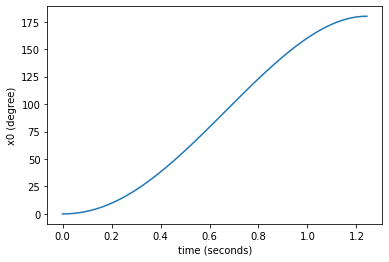

In [9]:
plt.figure()
plt.plot(times, x_list)
plt.xlabel("time (seconds)")
plt.ylabel("x0 (degree)");

# Simulation with block diagrams

In this chapter, and throughout the notes, we will be building up our simulations and controllers using drake's block diagram modeling language (we call it the "systems framework").  [This tutorial](https://mybinder.org/v2/gh/RobotLocomotion/drake/nightly-release?filepath=tutorials/dynamical_systems.ipynb)  provides a brief introduction.  


# Simulating the (passive) iiwa

Let's load our robot of choice (the Kuka iiwa) into the physics engine, which we call [MultibodyPlant](https://drake.mit.edu/doxygen_cxx/classdrake_1_1multibody_1_1_multibody_plant.html).


In [4]:
plant = MultibodyPlant(time_step=1e-4)
Parser(plant).AddModelFromFile(
        FindResourceOrThrow("drake/manipulation/models/iiwa_description/sdf/iiwa14_no_collision.sdf"))
plant.WeldFrames(plant.world_frame(), plant.GetFrameByName("iiwa_link_0"))
plant.Finalize()

In Drake, we are very careful to separate the *state* of a system from the system itself.  For example, let's think of a dynamical system as given by the difference equation: $$x[n+1] = f(n, x[n], u[n]),$$ where $n$ is the "time", $x$ is the state, and $u$ is any inputs to the system.  The `System` describes $f()$, but we use a structure called the [`Context`](https://drake.mit.edu/doxygen_cxx/classdrake_1_1systems_1_1_context.html) to hold the runtime values: $n, x, u$.  We use a structure, because some systems have even more runtime values, that describe system parameters, random noise inputs, etc, and it is cleaner to pass a structure around than have each system accept a different list of possible inputs.  As a rule `System` is constant over the duration of a simulation, and you should be able to obtain repeatable, deterministic simulations given any value `Context`.

Let's see what the `Context` looks like for the physics engine now that we've loaded the iiwa into it.

In [5]:
context = plant.CreateDefaultContext()
print(context)

::_ Context
------------
Time: 0
States:
  1 discrete state groups with
     14 states
       0 0 0 0 0 0 0 0 0 0 0 0 0 0

Parameters:
  38 numeric parameter groups with
     1 parameters
       0
     1 parameters
       1
     1 parameters
       0
     1 parameters
       1
     1 parameters
       0
     1 parameters
       1
     1 parameters
       0
     1 parameters
       1
     1 parameters
       0
     1 parameters
       1
     1 parameters
       0
     1 parameters
       1
     1 parameters
       0
     1 parameters
       1
     10 parameters
       nan nan nan nan nan nan nan nan nan nan
     10 parameters
            5   -0.1      0   0.07 0.0149 0.0269  0.016      0  0.007      0
     10 parameters
             5.76          0      -0.03       0.12  0.0210292  0.0201812 0.00303542          0          0     0.0036
     10 parameters
             6.35     0.0003      0.059      0.042  0.0100481 0.00655149 0.00521337  -1.77e-05  -1.26e-05  -0.002478
     10 parameters

The system has 14 state variables -- these are the 7 joint positions and 7 joint velocities for the iiwa.  Those states are discrete, because we passed a non-zero `time_step` to the constructor of the `MultibodyPlant`, which means the physics engine will be use a time-stepping simulation scheme (this will be the most performant when we start simulating contact).  Go ahead and try changing `time_step` to zero, and see what happens.

You'll notice the context has lots of parameters (currently these include the mass, the center of mass, and the inertia of each body).  You won't need those any time soon, but it does enable some super cool advanced features.

Because the `Context` for a `MultibodyPlant` can get quite complicated, `MultibodyPlant` offers some methods that help you get/set the values.  Let's set some non-zero initial positions.

In [6]:
# Set all of the joint positions at once in a single vector.
plant.SetPositions(context, [-1.57, 0.1, 0, 0, 0, 1.6, 0])
# You can also set them by referencing particular joints.
plant.GetJointByName("iiwa_joint_4").set_angle(context, -1.2)
print(context)

::_ Context
------------
Time: 0
States:
  1 discrete state groups with
     14 states
       -1.57   0.1     0  -1.2     0   1.6     0     0     0     0     0     0     0     0

Parameters:
  38 numeric parameter groups with
     1 parameters
       0
     1 parameters
       1
     1 parameters
       0
     1 parameters
       1
     1 parameters
       0
     1 parameters
       1
     1 parameters
       0
     1 parameters
       1
     1 parameters
       0
     1 parameters
       1
     1 parameters
       0
     1 parameters
       1
     1 parameters
       0
     1 parameters
       1
     10 parameters
       nan nan nan nan nan nan nan nan nan nan
     10 parameters
            5   -0.1      0   0.07 0.0149 0.0269  0.016      0  0.007      0
     10 parameters
             5.76          0      -0.03       0.12  0.0210292  0.0201812 0.00303542          0          0     0.0036
     10 parameters
             6.35     0.0003      0.059      0.042  0.0100481 0.00655149 0.0052

The iiwa model also defined 7 actuators.  Before we can run a simulation, we need to provide some values for those inputs to the `MultibodyPlant` `actuation_input_port`.  For this warm-up, we'll just set them to zero.

In [7]:
plant.get_actuation_input_port().FixValue(context, np.zeros(7));

Now we can set up and run a simulation.

In [8]:
simulator = Simulator(plant, context)
simulator.AdvanceTo(5.0)
print(context)

::_ Context
------------
Time: 5
States:
  1 discrete state groups with
     14 states
          -1.53094     2.09596  -0.0164143   -0.689525     2.92045    0.808656    -0.26988   -0.105265 -0.00676876    0.221284     4.05477   -0.934276     3.10094     7.11235

Parameters:
  38 numeric parameter groups with
     1 parameters
       0
     1 parameters
       1
     1 parameters
       0
     1 parameters
       1
     1 parameters
       0
     1 parameters
       1
     1 parameters
       0
     1 parameters
       1
     1 parameters
       0
     1 parameters
       1
     1 parameters
       0
     1 parameters
       1
     1 parameters
       0
     1 parameters
       1
     10 parameters
       nan nan nan nan nan nan nan nan nan nan
     10 parameters
            5   -0.1      0   0.07 0.0149 0.0269  0.016      0  0.007      0
     10 parameters
             5.76          0      -0.03       0.12  0.0210292  0.0201812 0.00303542          0          0     0.0036
     10 parame

# Visualizing the scene

The best way to visualize the results of a physics engine is with a 2D or 3D visualizer. For that, we need to add the system which curates the geometry of a scene (the geometry engine); in Drake with call it the [`SceneGraph`](https://drake.mit.edu/doxygen_cxx/classdrake_1_1geometry_1_1_scene_graph.html). Once we have a `SceneGraph`, then there are a number of different visualizers and sensors that we can add to the system to actually render the scene.

We support a number of visualizers in drake (we ship a simple VTK-based "drake-visualizer" with our binary releases, or you can use RViz).  But because we're working in a jupyter notebook, and want you to be able to run 3D graphics on any machine without any installation required, we'll use the [MeshCat](https://github.com/rdeits/meshcat) visualizer throughout these notes.  

To use all three systems (`MultibodyPlant`, `SceneGraph`, and `MeshcatVisualizer`), we need to assemble them into a [`Diagram`](https://drake.mit.edu/doxygen_cxx/classdrake_1_1systems_1_1_diagram.html) using a [`DiagramBuilder`](https://drake.mit.edu/doxygen_cxx/classdrake_1_1systems_1_1_diagram_builder.html).  Often you would add each system and then connect the ports together, but for common cases like we have here, we provide helper methods to reduce the boilerplate.

In [9]:
builder = DiagramBuilder()

# Adds both MultibodyPlant and the SceneGraph, and wires them together.
plant, scene_graph = AddMultibodyPlantSceneGraph(builder, time_step=1e-4)
# Note that we parse into both the plant and the scene_graph here.
Parser(plant, scene_graph).AddModelFromFile(
        FindResourceOrThrow("drake/manipulation/models/iiwa_description/sdf/iiwa14_no_collision.sdf"))
plant.WeldFrames(plant.world_frame(), plant.GetFrameByName("iiwa_link_0"))
plant.Finalize()

# Adds the MeshcatVisualizer and wires it to the SceneGraph.
meshcat = ConnectMeshcatVisualizer(builder, scene_graph, zmq_url=zmq_url)

diagram = builder.Build()

Connecting to meshcat-server at zmq_url=tcp://127.0.0.1:6006...
You can open the visualizer by visiting the following URL:
http://127.0.0.1:7006/static/
Connected to meshcat-server.


If you click on the link above, you can open a browser window to see the visualization.

But the scene will be empty so far.  We need to actually construct the diagram and ask it to publish.  (You normally don't have to call these; MeshcatVisualizer will automatically load at initialization and publish on a fixed period during simulation).

In [10]:
context = diagram.CreateDefaultContext()
meshcat.load()
diagram.Publish(context)

We've put together quite a complex system now.  A `Diagram` is just another `System`, so it has an associated context.

In [11]:
print(context)

::_ Context (of a Diagram)
---------------------------
14 total discrete states in 1 groups
284 total numeric parameters in 38 groups
1 total abstract parameters

::_::plant Context
-------------------
Time: 0
States:
  1 discrete state groups with
     14 states
       0 0 0 0 0 0 0 0 0 0 0 0 0 0

Parameters:
  38 numeric parameter groups with
     1 parameters
       0
     1 parameters
       1
     1 parameters
       0
     1 parameters
       1
     1 parameters
       0
     1 parameters
       1
     1 parameters
       0
     1 parameters
       1
     1 parameters
       0
     1 parameters
       1
     1 parameters
       0
     1 parameters
       1
     1 parameters
       0
     1 parameters
       1
     10 parameters
       nan nan nan nan nan nan nan nan nan nan
     10 parameters
            5   -0.1      0   0.07 0.0149 0.0269  0.016      0  0.007      0
     10 parameters
             5.76          0      -0.03       0.12  0.0210292  0.0201812 0.00303542          0

You can see that there is one additional "abstract state" from the `SceneGraph`.  `MeshcatVisualizer` is stateless.  Actually `SceneGraph` should really be stateless for these simple examples, too [#9501](https://github.com/RobotLocomotion/drake/issues/9501).

It's also very useful to draw the actual block diagram.

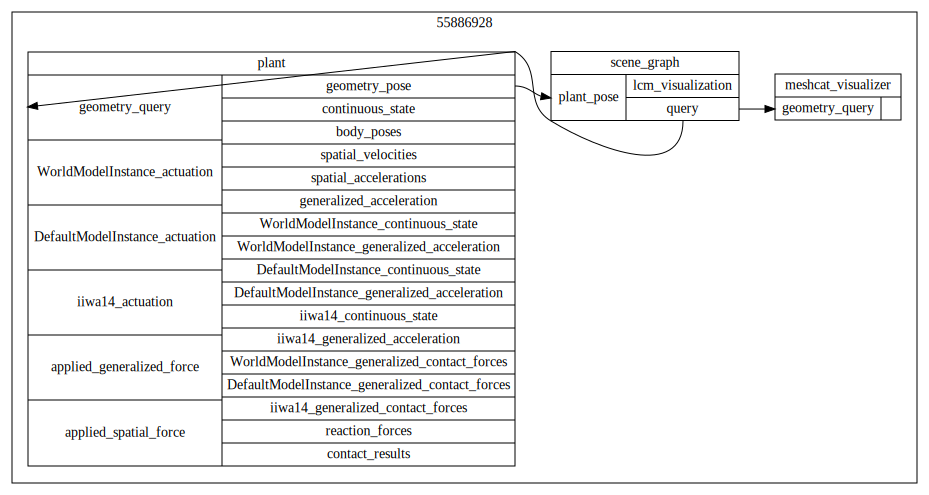

In [12]:
SVG(pydot.graph_from_dot_data(diagram.GetGraphvizString())[0].create_svg())

There is one more important detail: **The `Context` for the `Diagram` is not the `Context` of the `MultibodyPlant`.  But you can extract the plant `Context`; and we need to in order to set the initial conditions of the robot.

In [13]:
plant_context = plant.GetMyMutableContextFromRoot(context)
plant.SetPositions(plant_context, [-1.57, 0.1, 0, -1.2, 0, 1.6, 0])
plant.get_actuation_input_port().FixValue(plant_context, np.zeros(7))
print(context)

::_ Context (of a Diagram)
---------------------------
14 total discrete states in 1 groups
284 total numeric parameters in 38 groups
1 total abstract parameters

::_::plant Context
-------------------
Time: 0
States:
  1 discrete state groups with
     14 states
       -1.57   0.1     0  -1.2     0   1.6     0     0     0     0     0     0     0     0

Parameters:
  38 numeric parameter groups with
     1 parameters
       0
     1 parameters
       1
     1 parameters
       0
     1 parameters
       1
     1 parameters
       0
     1 parameters
       1
     1 parameters
       0
     1 parameters
       1
     1 parameters
       0
     1 parameters
       1
     1 parameters
       0
     1 parameters
       1
     1 parameters
       0
     1 parameters
       1
     10 parameters
       nan nan nan nan nan nan nan nan nan nan
     10 parameters
            5   -0.1      0   0.07 0.0149 0.0269  0.016      0  0.007      0
     10 parameters
             5.76          0      -0.0

Accidentally using `context` instead of `plant_context` is a very common mistake!

Ok, now we're ready to simulate.  Make sure your visualizer window is visible, then run the following cell.

In [14]:
simulator = Simulator(diagram, context)
simulator.set_target_realtime_rate(1.0)
simulator.AdvanceTo(5.0 if running_as_notebook else 0.1)

Glorious!

Here's one more trick.  You can ask MeshCat to record the animation, and then review it in the visualizer.  I'll repeat the preamble here to make this cell stand-alone.  (Plus we cannot reuse a system in multiple diagrams; the ownership is restricted).

In [ ]:
builder = DiagramBuilder()

# Adds both MultibodyPlant and the SceneGraph, and wires them together.
plant, scene_graph = AddMultibodyPlantSceneGraph(builder, time_step=1e-4)
# Note that we parse into both the plant and the scene_graph here.
Parser(plant, scene_graph).AddModelFromFile(
        FindResourceOrThrow("drake/manipulation/models/iiwa_description/sdf/iiwa14_no_collision.sdf"))
plant.WeldFrames(plant.world_frame(), plant.GetFrameByName("iiwa_link_0"))
plant.Finalize()

# Adds the MeshcatVisualizer and wires it to the SceneGraph.
meshcat = ConnectMeshcatVisualizer(builder, scene_graph, zmq_url=zmq_url, delete_prefix_on_load=False)

diagram = builder.Build()
context = diagram.CreateDefaultContext()
plant_context = plant.GetMyMutableContextFromRoot(context)
plant.SetPositions(plant_context, [-1.57, 0.1, 0, -1.2, 0, 1.6, 0])
plant.get_actuation_input_port().FixValue(plant_context, np.zeros(7))

simulator = Simulator(diagram, context)
simulator.set_target_realtime_rate(1.0)

meshcat.start_recording()
simulator.AdvanceTo(5.0 if running_as_notebook else 0.1)
meshcat.stop_recording()
meshcat.publish_recording()

Connecting to meshcat-server at zmq_url=tcp://127.0.0.1:6006...
You can open the visualizer by visiting the following URL:
http://127.0.0.1:7006/static/
Connected to meshcat-server.


# Adding the iiwa controller

The iiwa hardware interface runs through a control system provided by the manufacturer.  We can't turn it off.  The best we can do is add our approximation of it to our simulation.  I'll repeat everything we've set up before (to keep this example self-contained), but we'll add one more system for the controller.

In [ ]:
builder = DiagramBuilder()

# Adds both MultibodyPlant and the SceneGraph, and wires them together.
plant, scene_graph = AddMultibodyPlantSceneGraph(builder, time_step=1e-4)
# Note that we parse into both the plant and the scene_graph here.
iiwa_model = Parser(plant, scene_graph).AddModelFromFile(
        FindResourceOrThrow("drake/manipulation/models/iiwa_description/sdf/iiwa14_no_collision.sdf"))
plant.WeldFrames(plant.world_frame(), plant.GetFrameByName("iiwa_link_0"))
plant.Finalize()

# Adds the MeshcatVisualizer and wires it to the SceneGraph.
meshcat = ConnectMeshcatVisualizer(builder, scene_graph, zmq_url=zmq_url, delete_prefix_on_load=False)

# Adds an approximation of the iiwa controller.
# TODO(russt): replace this with the joint impedance controller.
Kp = np.full(7, 100)
Ki = 2 * np.sqrt(Kp)
Kd = np.full(7, 1)
iiwa_controller = builder.AddSystem(InverseDynamicsController(plant, Kp, Ki, Kd, False))
iiwa_controller.set_name("iiwa_controller");
builder.Connect(plant.get_state_output_port(iiwa_model),
                iiwa_controller.get_input_port_estimated_state())
builder.Connect(iiwa_controller.get_output_port_control(),
                plant.get_actuation_input_port())
diagram = builder.Build()

Let's see what our diagram looks like...

In [ ]:
SVG(pydot.graph_from_dot_data(diagram.GetGraphvizString())[0].create_svg())

As our diagrams get more complex, we're going to need a better approach to rendering the diagrams.  I've got a rough first pass (that it still suffering from some licensing issues) in javascript that I aim to improve.

TODO(russt): Update the javascript rendering [#13874](https://github.com/RobotLocomotion/drake/issues/13874).  

In [ ]:
diagram.set_name("diagram")
HTML('<script src="https://unpkg.com/gojs/release/go.js"></script>' + GenerateHtml(diagram))

To set up the `Context` now, instead of setting the `actuation_input` to zero, we set the `desired_state` of the iiwa controller to be the current position of the arm.  But the desired *state* must also include desired velocities, so we set those to zero.

In [ ]:
context = diagram.CreateDefaultContext()
plant_context = plant.GetMyMutableContextFromRoot(context)
q0 = np.array([-1.57, 0.1, 0, -1.2, 0, 1.6, 0])
x0 = np.hstack((q0, 0*q0))
plant.SetPositions(plant_context, q0)
iiwa_controller.GetInputPort('desired_state').FixValue(
    iiwa_controller.GetMyMutableContextFromRoot(context), x0)
print(context)

Now, if we simulate, the robot just stays put.  Just like the real robot would.

In [ ]:
simulator = Simulator(diagram, context)
simulator.set_target_realtime_rate(1.0);
simulator.AdvanceTo(5.0 if running_as_notebook else 0.1);

# Robot hands

I don't have the same smörgåsbord of robot models to offer for robot hands (yet).  We do have the allegro hand model available, and I'm happy to add more here (though many will require some care to handle their kinematic constraints).  For now, you can at least try out the [Allegro Hand](http://www.wonikrobotics.com/Allegro-Hand.htm).

TODO(russt): Consider porting Robotiq, Sandia, or IHY-hand from our [openhumanoids](https://github.com/openhumanoids/oh-distro/tree/master/software/models/common_components) project.

In [ ]:
def hand_sliders():
    builder = DiagramBuilder()

    plant, scene_graph = AddMultibodyPlantSceneGraph(builder, time_step=0.0)
    allegro_file = FindResourceOrThrow("drake/manipulation/models/allegro_hand_description/sdf/allegro_hand_description_right.sdf")
    Parser(plant, scene_graph).AddModelFromFile(allegro_file)
    plant.Finalize()

    meshcat = ConnectMeshcatVisualizer(builder, scene_graph, zmq_url=zmq_url)
    diagram = builder.Build()
    context = diagram.CreateDefaultContext()

    meshcat.load()
    MakeJointSlidersThatPublishOnCallback(plant, meshcat, context)

hand_sliders()